In [1]:
import numpy as np
import matplotlib.pyplot as plt

Data Model: data = signal+noise    
signal           = Ax+mu  
x is a random number drawn from a standard normal distribution, < x >=0, <x^2>=1    
the noise is Gaussian with mean =< noise >=0 and variance = < ( x-< x >)**2 >=sigma^2

A and mu depend on the parameters a,b. a and b are the parameters we are interested in inferring.

In [2]:
#get A as a function of a,b
def get_A(a,b,dim=1):
    A = a**2*np.ones((dim,dim))+b/2.
    return A

In [3]:
#get mu as a function of a,b
def get_mu(a,b, dim=1):
    mu = a**3/np.exp(b)*np.ones(dim)
    return mu

Fiducial Parameters (this is the underlying truth)

In [4]:
a_0=2; b_0=0.5

In [5]:
A_0  = get_A(a_0,b_0)
mu_0 = get_mu(a_0, b_0)

Noise level

In [6]:
sigma = 0.1

In [7]:
def generate_noise(sigma,dim=1,nsamples=100,rand_seed=None):
    np.random.seed(rand_seed)
    noise = np.random.randn(nsamples,dim)*sigma
    return noise

In [8]:
def generate_signal(A,mu,sigma,dim=1, nsamples=100,rand_seed=None):
    
    np.random.seed(rand_seed)
    x      = np.random.randn(nsamples,dim)
    signal = A*x+mu
    
    return signal

In [9]:
def generate_data(A,mu,sigma,dim,nsamples,rand_seed=None):
    
    signal = generate_signal(A,mu,sigma,dim,nsamples,rand_seed)
    noise  = generate_noise(sigma,dim,nsamples,rand_seed)
    data   = signal+noise
    
    return data

fiducial data (that's the assumed truth)

In [10]:
fid_data = generate_data(A_0,mu_0,sigma,dim=1, nsamples=1000,rand_seed=None)

In [11]:
def Gaussian(x,Mu,Sigma):
    return 1/np.sqrt(np.pi*2.)/Sigma*np.exp(-0.5*(x-Mu)**2/Sigma**2)

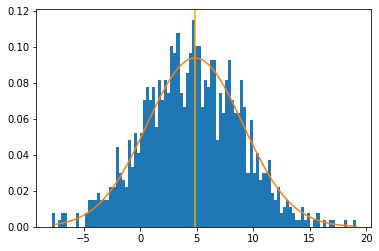

In [12]:
_, bins,_ = plt.hist(fid_data, density=True,bins=100)
plt.axvline(mu_0,color='orange')
delta = np.diff(bins) 
bins  = bins[0:-1]+delta
plt.plot(bins,np.squeeze(Gaussian(bins,mu_0,(A_0**2+sigma**2)**(0.5))))
plt.show()

#### Fit P(A|d) by Fisher Analysis

Here, we assume that P(data|parameters) is given. The real data is one a sample drawn from this distribution. From this we want to infer the true parameter distribution P(params|data). The prior P(params) is flat.
We want to look at P(params|data) in two ways:  
1) brute-force evaluation (this is possible, because we only have two parameters, if we had more this would soon become computationally intractable)    
2) Fisher analysis: find the maximum of P(params|data): argmax(P)=params* and fit a Gaussian with mean = param* and C= d/dparams_ij P(params|data)|params=params*

In [734]:
#this function returns a 1d Gaussian
def get_Gaussian_1d(mu,Sigma):    
    def Gaussian(x):
        return 1/np.sqrt((2.*np.pi))/Sigma*np.exp(-0.5*(x-mu)**2/Sigma**2)    
    return Gaussian

#this function returns an Nd Gaussian
def get_Gaussian_nd(mu,Sigma):
    Cinv = np.linalg.inv(Sigma)
    N    = mu.shape[-1]
    def Gaussian(x):
        x_ = x-mu
        return 1./np.sqrt(np.linalg.det(2*np.pi*Sigma))*np.exp(-0.5*np.einsum('ij,jk,ik->i',x_,Cinv,x_))
    return Gaussian

In [735]:
def get_Sigma(params):
    a,b = params
    return a**2*3+1.

def get_mu(params):
    a,b = params
    return (b-2)**2

In [736]:
# this function returns P(data|params)
def data_probability(params,data):
    Sigma = get_Sigma(params)
    mu    = get_mu(params)
    prob  = get_Gaussian_1d(mu, Sigma)
    return prob(data)

In [737]:
# this function computes the derivative of a function wrt to params
def finite_diff(params,func,h=1e-2):
    result = np.zeros(len(params))
    for ii in range(len(params)):
        delta_params     = np.zeros_like(params)
        delta_params[ii] = h
        derivative       = (func(params+delta_params)-func(params-delta_params))/(2*h)
        result[ii]       = derivative 
    return result

In [738]:
from functools import partial

In [739]:
# this function draws a data sample from P(data|params)
def generate_data(params):
    Sigma = get_Sigma(params)
    mu    = get_mu(params)
    data  = Sigma*np.random.randn(1)+mu
    return data

In [740]:
# these are pour true, underlying parameters
true_params = [1,0.4]

In [741]:
# which we use to create one single data sample
data = generate_data(true_params)
# to reproduce my results:
# data= 3.90317064

In [742]:
p_of_params = partial(data_probability, data=data)
deriv       = partial(finite_diff,func=p_of_params, h=1e-3)

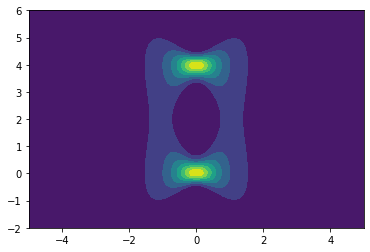

In [756]:
#  let's first sample P(params|data) on a grid
a_ = np.linspace(-5,5,100)
b_ = np.linspace(-2,6,100)
a_, b_ = np.meshgrid(a_,b_)
p  = p_of_params([a_,b_])

# and plot 
fig,ax=plt.subplots(1,1)
cp = ax.contourf(a_, b_, p)
plt.show()

In [752]:
# now let's turn to the Fisher analysis
from scipy.optimize import fsolve, minimize

In [753]:
# these are our starting guesses for the minimization
params_init = [0.5,1.]

(array([0.98373016, 2.        ]), {'nfev': 20, 'fjac': array([[-0.9991343 ,  0.04160119],
       [-0.04160119, -0.9991343 ]]), 'r': array([-0.28422451, -0.0013176 ,  0.03168749]), 'qtf': array([-3.43635239e-14,  4.08318660e-13]), 'fvec': array([-0., -0.])}, 1, 'The solution converged.')
[0.98373016 2.        ]
[0. 0.]


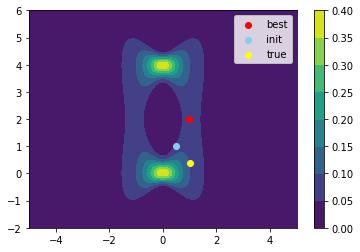

In [764]:
# this solver tries to minimize the derivative, to find the maximum
output= fsolve(lambda x: -deriv(x),params_init,full_output=True,maxfev=1000,xtol=1e-10)
print(output)
best_params= output[0]
print(best_params)
print(deriv(best_params))

fig,ax=plt.subplots(1,1)
cp = ax.contourf(a_, b_, p)
plt.scatter(best_params[0],best_params[1],color='red',label='best')
plt.scatter(params_init[0],params_init[1],color='skyblue',label='init')
plt.scatter(true_params[0],true_params[1],color='yellow',label='true')
fig.colorbar(cp)
plt.legend()
plt.show()

# for these starting values, it finds a saddle point and not the maximum!

 final_simplex: (array([[ 2.71642395e-05,  2.43638985e-02],
       [-2.18128071e-05,  2.43325781e-02],
       [-3.28545656e-05,  2.43741967e-02]]), array([-0.39894228, -0.39894228, -0.39894228]))
           fun: -0.3989422793058158
       message: 'Optimization terminated successfully.'
          nfev: 83
           nit: 43
        status: 0
       success: True
             x: array([2.71642395e-05, 2.43638985e-02])
[2.71642395e-05 2.43638985e-02]
[-6.50213914e-05 -4.98713868e-05]


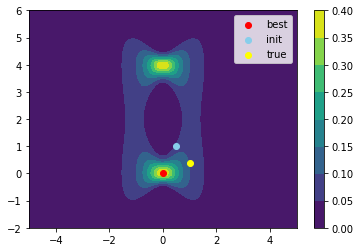

In [784]:
#let's switch to minimization instead. This is the Nelder-Mead algorithm
result = minimize(lambda params: -p_of_params(params),params_init, method='Nelder-Mead')
print(result)
best_params=result['x']

print(best_params)
print(deriv(best_params))

fig,ax=plt.subplots(1,1)
cp = ax.contourf(a_, b_, p)
plt.scatter(best_params[0],best_params[1],color='red',label='best')
plt.scatter(params_init[0],params_init[1],color='skyblue',label='init')
plt.scatter(true_params[0],true_params[1],color='yellow',label='true')
fig.colorbar(cp)
plt.legend()
plt.show()
## -> it works very well

      fun: array([-0.39894228])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.55351296e-12, -1.79578574e-11])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 27
      nit: 11
   status: 0
  success: True
        x: array([1.07130955e-12, 2.43558915e-02])
[1.07130955e-12 2.43558915e-02]
[-2.55351296e-12  1.79578574e-11]


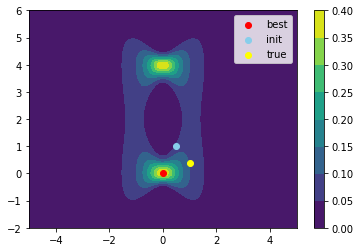

In [778]:
#let's try another algorithm
result = minimize(lambda params: -p_of_params(params),params_init, jac=lambda params: -deriv(params), method='L-BFGS-B', options=dict(gtol=1e-40,ftol=1e-40))
print(result)
best_params=result['x']

print(best_params)
print(deriv(best_params))

fig,ax=plt.subplots(1,1)
cp = ax.contourf(a_, b_, p)
plt.scatter(best_params[0],best_params[1],color='red',label='best')
plt.scatter(params_init[0],params_init[1],color='skyblue',label='init')
plt.scatter(true_params[0],true_params[1],color='yellow',label='true')
fig.colorbar(cp)
plt.legend()
plt.show()
## -> it works very well, too, but try a different starting value: (2,2), what happens there?

Can you try other algorithms? :) 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
Some of them require a Hessian - you might already have a finite differencing function for Hessians. (See also next question)
Try to find out what these different algorithms do differently.

If you have coded the Hessian yourself and want to check your implementation, or if you want to skip that step and get the Hessian for free, check out 'numdifftools'. To install simply run "pip install numdifftools" after activating your conda environment.


Can you compute the Fisher information from finite differencing and plot the Gaussian that we get to approximate P(params|data) from the Fisher analysis?

In [795]:
import numdifftools as nd
F           = nd.Hessian(p_of_params)(best_params)
C           = np.linalg.inv(Hessian)
print(C)

[[-4.17771385e-01 -1.68730794e-09]
 [-1.68730794e-09 -1.60552789e-01]]


In [796]:
approx_posterior = get_Gaussian_nd(best_params,C)
print(best_params)

[2.71642395e-05 2.43638985e-02]


In [797]:
pp = approx_posterior(np.vstack((a_.flatten(),b_.flatten())).T).reshape(a_.shape)

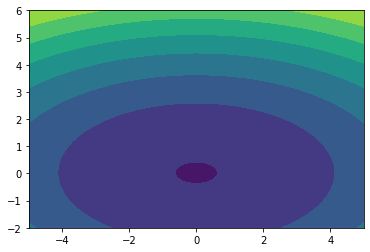

In [798]:
fig,ax = plt.subplots(1,1)
ax.contourf(a_,b_,np.log(pp))
plt.show()

What do you notice? Is it a good approximation? Why? Why not?
How could we improve on this?

Imagine we can do more than one measurement. How would we combine many data points? 
Can you get and plot the the posterior P(params|data1,data2,data3...) ?